<div class="alert alert-success">
<b>Reviewer's comment V3</b>
	  
Thank you for taking the time to improve the project! Now it is accepted. Good luck on the next sprint! :)
	  
</div>

**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, there's just one small problem that needs to be fixed before the project can be accepted. Should be pretty straightforward though!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
!pip install -U scikit-learn --upgrade # sklearn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (1.0.1)


### Imports

In [2]:
import pandas as pd
import numpy as np
import math
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer


from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Duplicates

In [6]:
df.duplicated().sum()

0

### Missing Values

In [7]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

### Converting & setting datetime as index

In [8]:
df.datetime = pd.to_datetime(df.datetime)
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you loaded the data and made sure it is in chronological order!
	  
</div>

### Resampling

In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data was resampled correctly
	  
</div>

### Conclusion
In this section, we:
* imported the required libraries
* loaded the data
* had a first look into the data
* looked into the data info
* displayed the descriptive statistics
* checked for duplicates
* checked for missing values
* converted & set datetime as index
* resampled the data

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Good!
	  
</div>

## Analysis

In [10]:
print('Minimal index:', df.index.min(), '\nMaximal index:', df.index.max())

Minimal index: 2018-03-01 00:00:00 
Maximal index: 2018-08-31 23:00:00


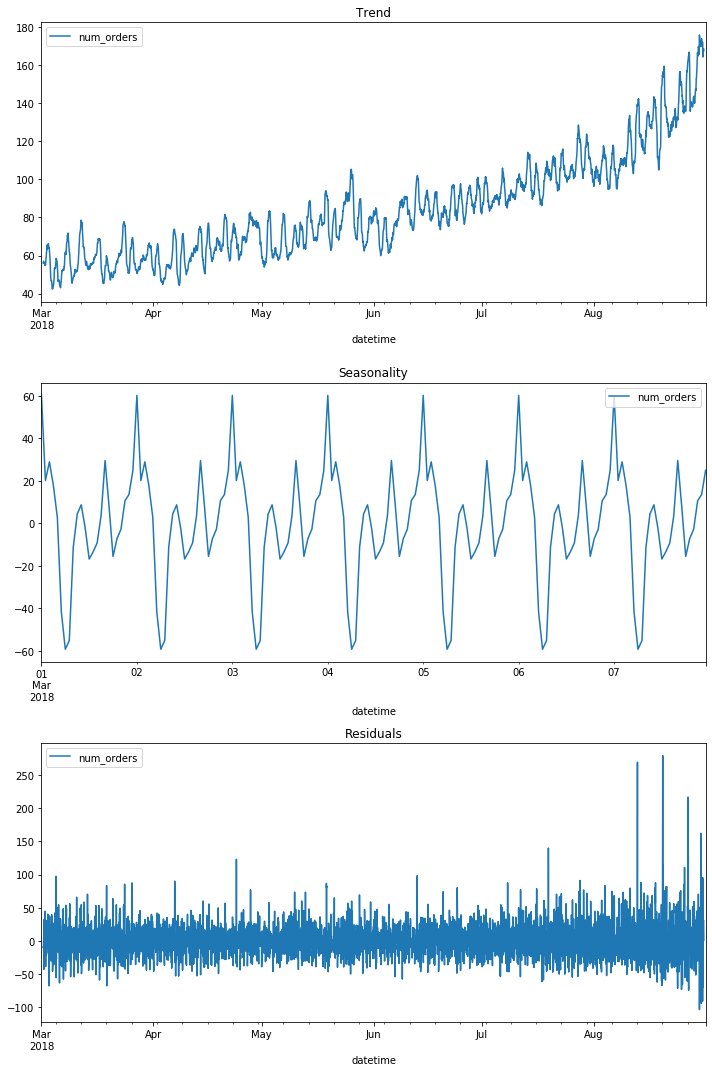

In [11]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(10, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01' : '2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

We can see the trend in the first plot: there are more orders over time.

We take only a week for seasonal plot: there is a pattern for everyday.

The residuals have a mean around zero.

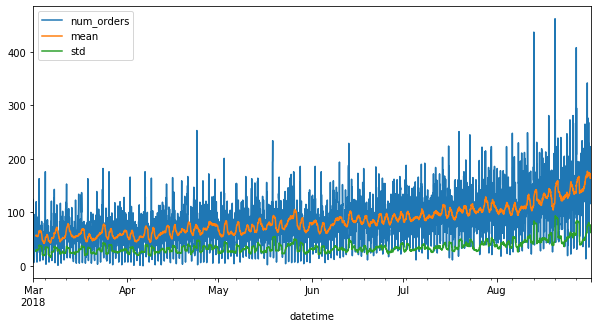

In [12]:
df['mean'] = df.num_orders.rolling(24).mean() 
df['std'] = df.num_orders.rolling(24).std() 

df.plot(figsize=(10, 5))
plt.show()

We added the rolling mean and std to the data. We can see that the mean and std changes over time, what means that our data is nonstationary.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you visualized the data, did a seasonal decomposition and noted some patterns
	  
</div>

### Converting to Stationary Series

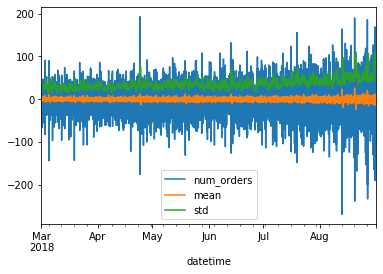

In [13]:
df -= df.shift()
df['mean'] = df.num_orders.rolling(15).mean()
df['std'] = df.num_orders.rolling(15).std()
df.plot()
plt.show()

In order to be able to predict with our models, we converted the data to stationary series.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
If you do this, don't forget to make an inverse transformation after making predictions
	  
</div>

## Training

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour']  = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.num_orders.shift(lag)

    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()

make_features(df, 4, 4)
print(df.head())

                     num_orders  mean  std  year  month  day  dayofweek  hour  \
datetime                                                                        
2018-03-01 00:00:00         NaN   NaN  NaN  2018      3    1          3     0   
2018-03-01 01:00:00       -39.0   NaN  NaN  2018      3    1          3     1   
2018-03-01 02:00:00       -14.0   NaN  NaN  2018      3    1          3     2   
2018-03-01 03:00:00        -5.0   NaN  NaN  2018      3    1          3     3   
2018-03-01 04:00:00       -23.0   NaN  NaN  2018      3    1          3     4   

                     lag_1  lag_2  lag_3  lag_4  rolling_mean  
datetime                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN           NaN  
2018-03-01 02:00:00  -39.0    NaN    NaN    NaN           NaN  
2018-03-01 03:00:00  -14.0  -39.0    NaN    NaN           NaN  
2018-03-01 04:00:00   -5.0  -14.0  -39.0    NaN 

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
The features look good! There are calendar features, lag features and a correctly shifted rolling mean. One obvious omission is current hour feature
	  
</div>

<div class="alert alert-info">
  Thanks :)
</div>

In order to train the models, we added some features, based on the data already have.

In [15]:
df = df.dropna()

train, test = train_test_split(df, shuffle=False, test_size=0.1)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data is split into train and test without shuffling
	  
</div>

### Features & Target

In [16]:
train_features = train.drop('num_orders', axis=1)
train_target = train.num_orders

test_features = test.drop('num_orders', axis=1)
test_target = test.num_orders

### Linear Regression

In [17]:
def rmse_score(Y, pred):
    return math.sqrt(mean_squared_error(Y, pred))

rmse = make_scorer(rmse_score, greater_is_better=False)

tscv = TimeSeriesSplit(n_splits=5)

In [18]:
lr = LinearRegression()
 
lr = GridSearchCV(lr, param_grid={}, cv=tscv, scoring=rmse)
lr.fit(train_features,train_target)

predictions = lr.predict(test_features)
predictions = pd.DataFrame(predictions)
print('The RMSE score (on test) is {:.3f}'.format(rmse_score(test_target, predictions)))

The RMSE score (on test) is 47.648


### Random Forest

In [19]:
params = {'n_estimators' : [3,10,20]}

rf = RandomForestRegressor(random_state=0)

rf = GridSearchCV(rf, param_grid=params, cv=tscv, scoring=rmse)
rf.fit(train_features,train_target)

predictions = rf.predict(test_features)
print('The best hyperparameters are: ',rf.best_params_)
print('The RMSE score (on test) is {:.3f}'.format(rmse_score(test_target, predictions)))

The best hyperparameters are:  {'n_estimators': 20}
The RMSE score (on test) is 38.460


### CatBoost Regressor

In [20]:
params = {'iterations' : [10, 50 , 100]}

cbr = CatBoostRegressor(verbose=0) 

cbr = GridSearchCV(cbr, param_grid=params, cv=tscv, scoring=rmse)
cbr.fit(train_features,train_target)

predictions = cbr.predict(test_features)
print('The best hyperparameters are: ',cbr.best_params_)
print('The RMSE score (on test) is {:.3f}'.format(rmse_score(test_target, predictions)))

The best hyperparameters are:  {'iterations': 100}
The RMSE score (on test) is 41.323


## Conclusion
We trained 3 models with the data. All of the models got RMSE score less than 48. The best model is random forest of n_estimators=20.

<div class="alert alert-danger">
<b>Reviewer's comment</b>
	  
It's nice that you tried a couple of different models and did some hypeprarameter tuning. One problem is that hyperparameters are tuned using the test set. To tune hyperparameters we either need to split the data into three parts (train, validation and test), or use cross-validation (for time series models, regular k-fold cross-validation is inappropriate due to data leakage, something like [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) is needed)
	  
</div>

<div class="alert alert-info">
  Thanks for your important comment, I hope it's okay now :)
</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>
	  
Almost, but not quite: now you have a validation set for tuning hyperparameters (great!), but then you go on to evaluate the model with different hyperparameters on the test set as well. When we tune hyperparameters using the validation set, it leads to a biased validation set score, so we need separate data which is not used for training/hypeprarameter tuning in any way to get an unbiased estimate. You may wonder, why do we care about getting an unbiased estimate? Well, if the estimate is biased, it's likely too optimistic, and that can lead to disappointing performance of the model when it rolls out in production. So, to sum up, the hyperparameters need to be fixed (using validation set/cross-validation) before the single final evaluation of the model on the test set.
	  
</div>

<div class="alert alert-info">
  I'm not sure that I understood your comment (because I used train, valid & test sets in the previous version as you proposed), but I changed the split method to TimeSeriesSplit. 
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>
	  
In the previous version, you were evaluating the model with different hyperparameters on both validation and test set, and that kind of defeats the point of separating them. The model's hyperparameters should be tuned only using the validation set/cross-vlaidation, and then only after we select the best hyperparameters, we can evaluate the final model on the test set. I hope this makes sense!
    
Anyway, now everything is correct! :)
	  
</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48